In [1]:
#pip install --upgrade openeo

In [1]:
from openeo.local import LocalConnection
import xarray as xr
from openeo.processes import and_, is_valid, filter_temporal
import pandas as pd
import numpy as np
import openeo

import geopandas as gpd
import leafmap
from datetime import datetime, timezone

from utils import create_geojson_bbox
import shapely

from openeo.rest.auth.config import RefreshTokenStore


/home/vpremier/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


## Gapfilling
<div>
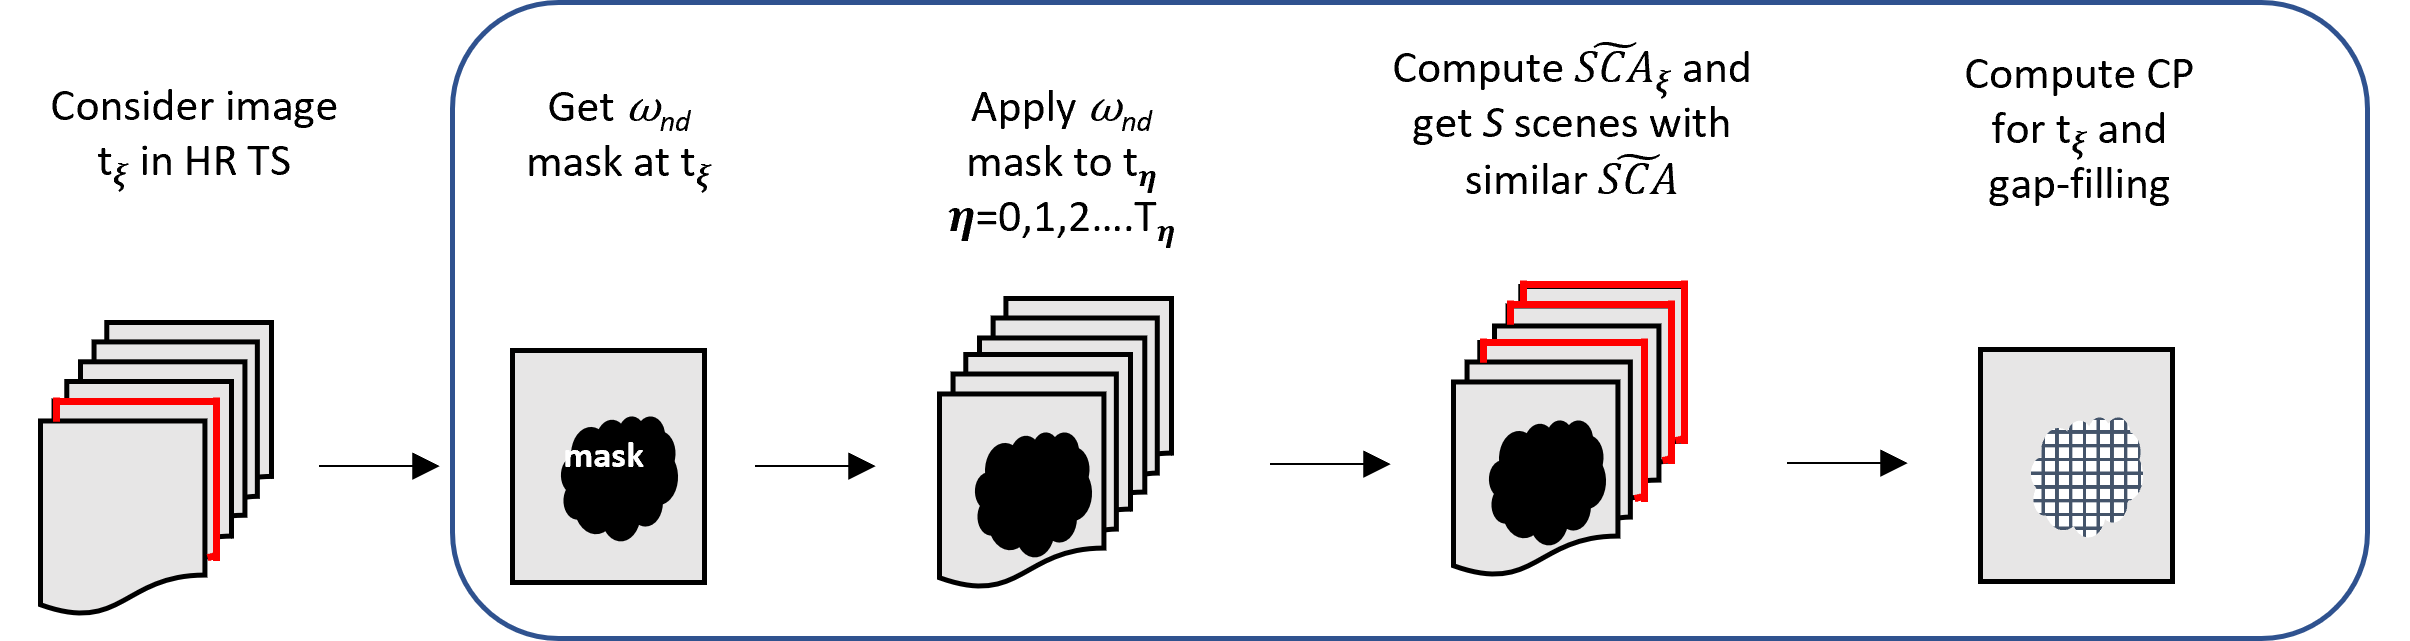
</div>


- Applied to any HR maps with gaps;
- Based on the partial observed/reconstructed SCA, i.e., the SCA computed by excluding the no data values;
- Conditional probability to observe a pixel as snow given the historical HR snow pattern persistence:

 
$$
P_{i}(\omega_{s}|\widetilde{SCA}) = \frac{\sum_{s=0}^{S}x_{i}^{s}}{S}, \: i \subset \text{mask}
$$

Hence it follows:

$$
\begin{split}
    x_{i}=\omega_{s}, \:  & \textbf{if} \:  P_{i}(\omega_{s}|\widetilde{SCA}) = 1 \\
     x_{i}=\omega_{sf}, \:  & \textbf{if} \:  P_{i}(\omega_{s}|\widetilde{SCA}) = 0 
\end{split}
$$


In [3]:
eoconn = openeo.connect("https://openeo-dev.vito.be")
eoconn.authenticate_oidc()

eoconn.describe_account()

Authenticated using refresh token.


{'info': {'oidc_userinfo': {'eduperson_assurance': ['https://refeds.org/assurance/IAP/low',
    'https://aai.egi.eu/LoA#Substantial'],
   'eduperson_entitlement': ['urn:mace:egi.eu:group:vo.openeo.cloud:role=member#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.openeo.cloud:role=vm_operator#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.pangeo.eu:role=member#aai.egi.eu',
    'urn:mace:egi.eu:group:vo.pangeo.eu:role=vm_operator#aai.egi.eu'],
   'eduperson_scoped_affiliation': ['employee@eurac.edu', 'member@eurac.edu'],
   'email': 'valentina.premier@eurac.edu',
   'email_verified': True,
   'sub': 'b5345703744f82d43e36ecfbbe263186fb2556417bd8fe0054ae63476450f901@egi.eu',
   'voperson_verified_email': ['Valentina.Premier@eurac.edu']}},
 'name': 'Valentina.Premier@eurac.edu',
 'user_id': 'b5345703744f82d43e36ecfbbe263186fb2556417bd8fe0054ae63476450f901@egi.eu'}

In [4]:
#RefreshTokenStore().remove()

In [5]:
shp_path = r'/mnt/CEPH_PROJECTS/PROSNOW/research_activity/Senales/auxiliary/boundaries/SenalesCatchment/SenalesCatchment.shp'

catchment_outline = gpd.read_file(shp_path)
bbox = catchment_outline.bounds.iloc[0]

center = (float(catchment_outline.centroid.y), 
          float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=1)
m.add_vector(shp_path, layer_name="catchment")

In [6]:
eps= 0.05 # buffer of ca. 500 m
scf = eoconn.load_collection(
    "FRACTIONAL_SNOW_COVER",
    spatial_extent  = {'west':bbox[0]-eps,
                       'east':bbox[2]+eps,
                       'south':bbox[1]-eps,
                       'north':bbox[3]+eps,
                       'crs':4326},
    temporal_extent=['2022-10-01','2023-09-30'],
    bands=["FSCTOC"]
)
#scf.download('scf.nc')

In [7]:
west=631810.
south=5167710.
east=655790.
north=5184190.
area = shapely.geometry.box(west, south, east, north) 
res = 20.

# check that the grid is aligned with a 500 m gri
print('Nr. of low-resolution pixels in the resampled grid (x): {}'.format((east + res/2. - (west - res/2. ))/500.))
print('Nr. of low-resolution pixels in the resampled grid (y): {}'.format((south - res/2. - (north + res/2. ))/-500.))

scf_rsmpl = scf.resample_spatial(resolution=res, 
                                 projection=32632,
                                 method = "cubic")

            
scf_bbox = scf_rsmpl.filter_bbox(west=west, 
                                 south=south, 
                                 east=east, 
                                 north=north, 
                                 crs=32632)
#scf_bbox.download(base_path + os.sep + 'scf_rsmp.nc'scf_bbox.download(base_path + os.sep + 'scf_rsmp.nc'#)
scf_bbox

Nr. of low-resolution pixels in the resampled grid (x): 48.0
Nr. of low-resolution pixels in the resampled grid (y): 33.0


In [8]:
binarize = openeo.UDF.from_file('udf-binarize.py', 
                                context={"from_parameter": "context"})


scf_binary = scf_bbox.apply(process=binarize, 
                            context={"snowT": 20})
#scf_binary.download('./results/scf_binary.nc')

Define constant values to be used in the notebook.

In [9]:
# Ratio betweeen the size of a LR and a HR pixel, e.g., 500 m and 20 m.
pixel_ratio = 25 
# non-valid values
codes = [205, 210, 254, 255] 
nv_value = 205
# Threshold of non valid HR pixels allowed within a LR pixel [%]
nv_thres = 10 

# delta and epsilon: are used to define the SCF ranges. 
# The delta defines the steps, while epsilon represents a security buffer
delta = 10
epsilon = 10

sim_thres = 95
sca_thres = 5.

In [10]:
# cloud/non valid pixels
cube_renamed = scf_binary.rename_labels(dimension="bands",
                                              target=["scf"])
def mask_clouds(data):
    binary = data.array_element(label = "scf")
    mask = binary > 100  
    return mask

def mask_snow(data):
    binary = data.array_element(label = "scf")
    mask = binary == 100  
    return mask

def mask_valid(data):
    binary = data.array_element(label = "scf")
    mask = binary <= 100  
    return mask

mask_clouds = cube_renamed.apply(mask_clouds)
mask_snow = cube_renamed.apply(mask_snow)
mask_valid = cube_renamed.apply(mask_valid)

#mask_clouds.download('./results/clouds.nc')

Get the time vector

In [ ]:
t = scf.dimension_labels('t')
t_array = t.execute() 

Get the AOI as GeoJson: works only in epsg 4326

In [ ]:
gdf = gpd.GeoDataFrame({'geometry': area}, index=[0], crs='32632')
gdf = gdf.to_crs('4326')
area_new = eval(gdf.to_json())
area_new
# small differences mazbe due to the reprojection?

Loop over time
For each date of the Sentinel-2 time-series, select the corresponding cloud mask and apply it to all the other dates of the time-series. 

In [ ]:
t_array
for date in t_array:
    print('Current date is: ' + date)
    
    # change format -> pandas datetime
    date_dt = pd.to_datetime(str(date),format= "%a, %d %b %Y %H:%M:%S %Z")
    date_dt = date_dt.replace(tzinfo=timezone.utc).astimezone(tz=None)
    
    # filter the cloud mask to the current time step 
    current_cloud = mask_clouds.filter_temporal([date_dt, date_dt + pd.Timedelta(1, "d")]).drop_dimension('t')
    
    # filter the time-series to the current time step 
    current_snow_map = scf_binary.filter_temporal([date_dt, date_dt + pd.Timedelta(1, "d")]).drop_dimension('t')
    
    # apply the mask to the time-series
    cube_masked = scf_binary.mask(current_cloud,replacement=255)
    
    # get the number of total valid pixels (in the non masked area)
    total = cube_masked <= 205
    sum_total = total.aggregate_spatial(geometries=area_new, reducer='sum')
    sum_total_cube = sum_total.vector_to_raster(scf_binary)
    sum_total_cube = sum_total_cube.rename_labels('bands', ['sum_tot'])
    
    # compute the percentage of similar pixels (same label)
    diff = cube_masked.subtract(current_snow_map)
    
    # similar pixels that are valid (both snow and snow free)
    similar = (diff == 0)*1.0
  
    sum_similar = similar.aggregate_spatial(geometries=area_new, reducer='sum')
    sum_similar_cube = sum_similar.vector_to_raster(scf_binary)
    sum_similar_cube = sum_similar_cube.rename_labels('bands', ['sum_similar'])
    
    sum_merged = sum_total_cube.merge_cubes(sum_similar_cube)

    similar_perc = sum_merged.band("sum_similar").divide(sum_merged.band("sum_tot")).multiply(100)
    
    # mask dates with similar values 
    mask_sim = (similar_perc > sim_thres)*1.0
    
    # consider the area in the current cloud
    snow = (mask_sim).merge_cubes(current_cloud, overlap_resolver="and").merge_cubes(mask_snow, overlap_resolver="and")
    total = (mask_sim).merge_cubes(current_cloud, overlap_resolver="and").merge_cubes(mask_valid, overlap_resolver="and")
    
    # how many times a pixels is snow over time
    sum_cp_snow = snow.reduce_dimension(reducer="sum", dimension="t")
    # how many times a pixels is valid over time (occurences)
    sum_cp_tot = total.reduce_dimension(reducer="sum", dimension="t")


    # compute the conditional probabilities
    cp = sum_cp_snow/sum_cp_tot
    
    break

In [28]:
cp.download('cp.nc')

In [41]:
cp

OpenEoApiError: [501] FeatureUnsupported: Feature not supported. (ref: r-24060613265843dda8188cd345bc6a90)